Building an AR char level LM with a transformer decoder nn. 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

In [2]:
# 32K names to train the model
with open("names.txt", "r") as f:
    words = f.read().splitlines()
    
# Add special start - end token
words = ['.' + words[i] + '.' for i in range(len(words))]

print(f"#Names {len(words)}")    
print(words[:5])

#Names 32033
['.emma.', '.olivia.', '.ava.', '.isabella.', '.sophia.']


In [3]:
# Encode - Decode dicts
itoc = {}
ctoi = {}

vocab = '.' + string.ascii_lowercase
vocab_size = len(vocab)

for i, c in enumerate(vocab):
    itoc[i] = c
    ctoi[c] = i

print(f"vocab_size is: {vocab_size}")
print(itoc)

vocab_size is: 27
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [4]:
# Dataset Construct (-1 masks not existing examples)
block_size = max([len(word) for word in words]) - 1
print(block_size)
print(f"Longest word is index: {torch.tensor([len(word) for word in words]).argmax()}")
print(words[torch.tensor([len(word) for word in words]).argmax()])

X, Y = [],[] 

for w in words:
    item = []
    for c in w:
        item.append(ctoi[c])
    X.append(torch.cat([torch.tensor(item[:-1]), torch.zeros((block_size - len(item[:-1])), dtype = torch.int)],0))
    Y.append(torch.cat([torch.tensor(item[1:]), (-1)*torch.ones((block_size - len(item[1:])), dtype = torch.int)],0))

X = torch.stack(X)
Y = torch.stack(Y)

print(X[0])
print(Y[0])

ix  = int(0.96*len(words))
Xtrain, Ytrain = X[:ix], Y[:ix] # 90%
Xtest, Ytest = X[ix:], Y[ix:] # 10%

print(Xtrain.shape, Ytrain.shape)
print(Xtest.shape, Ytest.shape)

16
Longest word is index: 31441
.muhammadibrahim.
tensor([ 0,  5, 13, 13,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
tensor([ 5, 13, 13,  1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])
torch.Size([30751, 16]) torch.Size([30751, 16])
torch.Size([1282, 16]) torch.Size([1282, 16])


In [5]:
class Single_head_SelfAttention(nn.Module):
    "Fancy desc"
    def __init__(self):
        super().__init__()
        self.key = nn.Linear(n_embedd, head_size, bias=False)
        self.query = nn.Linear(n_embedd, head_size, bias=False)
        self.value = nn.Linear(n_embedd, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
        
    def forward(self, x):
        B, T, C = x.shape
        q = self.query(x) # (B, T, H)
        k = self.key(x) # (B, T, H)
        # Compute Affinities
        wei = q @ k.transpose(-2, -1) * (k.shape[2])**(-0.5) # Batch mul (B, T, H) @ (B, H, T) --> (B, T, T)
        wei = wei.masked_fill(self.tril == 0, float('-inf')) # (B, T, T)
        # Compute final contextual representations
        wei = F.softmax(wei, dim = -1) # (B, T, T)
        out = wei @ self.value(x) # (B, T, T) * (B, T, H) ---> (B, T, H)
        
        return out
        

In [ ]:
key = nn.Linear(4, 2)
query = nn.Linear(4, 2)
value = nn.Linear(4, 2)
buf = torch.tril(torch.ones(6, 6))
x = torch.randn(2, 6, 4)
q = query(x) 
k = key(x) 
wei = q @ k.transpose(-2, -1) * (k.shape[2])**(-0.5)
wei = wei.masked_fill(buf == 0, float('-inf'))
print(wei.shape)
print(wei[0])
wei = F.softmax(wei, dim = -1)
print(wei.shape)
print(wei[0])
val = value(x)
out = wei @ val
print(val.shape)
print(val[0])
print(out.shape)
print(out[0])

In [6]:
class Multi_head_SelfAttention(nn.Module): 
    "Fancy desc"
    def __init__(self):
        super().__init__()
        self.heads = nn.ModuleList([Single_head_SelfAttention() for _ in range(heads)])
        self.proj = nn.Linear(n_embedd, n_embedd)
        
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim = -1) # (B, T, C)
        
        return self.proj(out) # (B, T, C)
        

In [7]:
class ffnn(nn.Module):
    "Fancy desc"
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embedd, 4 * n_embedd),
            nn.ReLU(),
            nn.Linear(4 * n_embedd, n_embedd)
        )

    def forward(self, x):
        return self.net(x)
    

In [8]:
class Decoder(nn.Module):
    "Fancy desc"
    def __init__(self):
        super().__init__()
        self.sa_heads = Multi_head_SelfAttention()
        self.ffnn = ffnn()
        self.ln_1 = nn.LayerNorm(n_embedd)
        self.ln_2 = nn.LayerNorm(n_embedd)
        
    def forward(self, x):
        x = x + self.sa_heads(self.ln_1(x)) # (B, T, C)
        x = x + self.ffnn(self.ln_2(x)) # (B, T, C)
        
        return x
        

In [9]:
class Transformer_Decoder(nn.Module):
    "Fancy desc"
    def __init__(self):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size,n_embedd)
        self.pos_emb = nn.Embedding(block_size,n_embedd) 
        self.blocks = nn.Sequential(*[Decoder() for _ in range(decoders)])
        self.ln_f = nn.LayerNorm(n_embedd) # final layer norm
        self.lm_head = nn.Linear(n_embedd, vocab_size)
        
    def forward(self, idx, targets = None):
        B, T = idx.shape
        
        tok_emb = self.token_emb(idx) # (B, T, C)
        po_emb = self.pos_emb(torch.arange(T)) # ( , T, C)
        emb = tok_emb + po_emb #  (B, T, C) + ( , T, C) --> (B, T, C)
        x = self.blocks(emb) # (B, T, C)
        x = self.ln_f(x) # (B, T, C)
        logits = self.lm_head(x) # (B, T, vocab_size)
        
        if targets is None:
            loss = None
        else:
            B, T, vocab_size = logits.shape
            logits = logits.view(B*T, vocab_size)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets, ignore_index=-1)

        return logits, loss
        
        

In [85]:
# Model Hyperparams
batch_size = 32 # B
block_size = 16 # T
n_embedd = 32 # C
heads = 4 
head_size = n_embedd//heads # n_embed = head_size * heads
decoders = 4

max_steps = 100000
learning_rate = 3e-4
weight_decay = 0.01

model = Transformer_Decoder()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=(0.9, 0.99), eps=1e-8)

# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters()), 'parameters')

# Track stats
lossi = []
val_loss1000i = []
counter = 0
min_delta = 0.05
patience = 3
min_validation_loss = float("+inf")

for i in range(max_steps):
    # Batch Creation
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,))
    Xb, Yb = Xtrain[ix], Ytrain[ix] # batch X,Y : (B, T)
    
    # evaluate the loss
    logits, loss = model(Xb, Yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    # early stopper
    if i % 1000 == 0:
        logits, val_loss = model(Xtest, Ytest)
        val_loss1000i.append(val_loss.log10().item())
        if val_loss < min_validation_loss:
            min_validation_loss = val_loss
            counter = 0
        elif val_loss > (min_validation_loss + min_delta):
            counter += 1
            if counter >= patience:
                break
    
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


52763 parameters
      0/ 100000: 3.3478
  10000/ 100000: 2.1106
  20000/ 100000: 1.8628
  30000/ 100000: 1.8052
  40000/ 100000: 1.8706
  50000/ 100000: 1.9127
  60000/ 100000: 1.8871
  70000/ 100000: 1.7884
  80000/ 100000: 1.8486


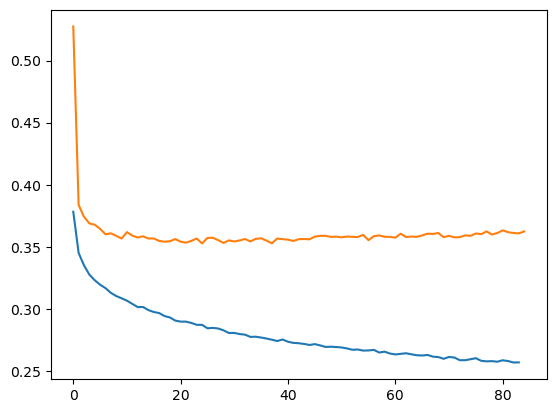

In [86]:
plt.figure(1)
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
plt.plot(val_loss1000i)
plt.show()

In [87]:
logits, train_loss = model(Xtrain, Ytrain)
logits, val_loss = model(Xtest, Ytest)

print(f"Training loss {train_loss}")
print(f"Validation loss {val_loss}")

Training loss 1.8141716718673706
Validation loss 2.3035144805908203


In [115]:
# sample from the model
g = torch.Generator().manual_seed(2147483645)

for _ in range(10):

    out = []
    context = [0] # initialize with .
    while True:
        # forward pass
        inp = torch.cat([torch.tensor(context), torch.zeros((block_size - len(context)), dtype = torch.int)], dim = 0)
        inp = torch.stack([inp])
        logits, loss = model(inp)
        # sample
        probs = F.softmax(logits.squeeze(), dim=1)
        ix = torch.multinomial(probs[len(context) - 1], num_samples=1, generator=g).item()
        context = context[-(block_size - 1):] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itoc[i] for i in out))

mackinley.
channer.
syrina.
corryna.
avygrian.
genarice.
aurieli.
margaretha.
elora.
rukhyn.


In [89]:
params = list(model.parameters())
mods = list(model.modules())[0]

In [90]:
# let's forward one example
ex1 = torch.cat([X[31441]]).unsqueeze(0) # (1, T)
print(ex1.shape)

torch.Size([1, 16])


In [94]:
# The essential layers 
token_emd = mods.token_emb
pos_emd = mods.pos_emb
ln_1 = mods.blocks[0].ln_1

In [103]:
# Forward pass to attention probabilities in the first layer
# Embedding
tok_emb = token_emd(ex1) # (B, T, C)
po_emb = pos_emd(torch.arange(block_size)) # ( , T, C)
emb = tok_emb + po_emb #  (B, T, C) + ( , T, C) --> (B, T, C)
# Norm
x = ln_1(emb) # (B, T, C)
# Attention
self_attention_head = mods.blocks[0].sa_heads.heads[3] # Choose the attention head to forward to
query = self_attention_head.query
key = self_attention_head.key
value = self_attention_head.value
q = query(x) # (B, T, H)
k = key(x) # (B, T, H)
buf = torch.tril(torch.ones(block_size, block_size))
# Compute Affinities
wei = q @ k.transpose(-2, -1) * (k.shape[2])**(-0.5) # Batch mul (B, T, H) @ (B, H, T) --> (B, T, T)
wei = wei.masked_fill(buf == 0, float('-inf')) # (B, T, T)
wei = F.softmax(wei, dim = -1) # (B, T, T)

print(wei.shape)

torch.Size([1, 16, 16])


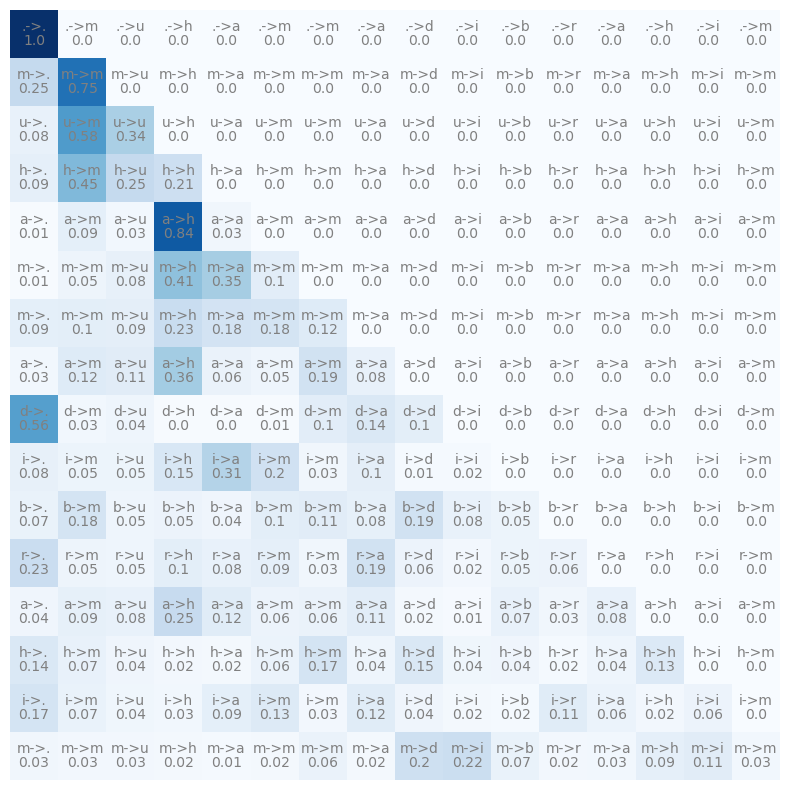

In [104]:
# Visualizing the attention maps of the first layer

%matplotlib inline

plt.figure(figsize=(10,10))
plt.imshow(wei[0].detach().numpy(), cmap='Blues')
for i in range(block_size):
    for j in range(block_size):
        chstr = words[31441][i] + "->" + words[31441][j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, round(wei[0][i, j].item(),2), ha="center", va="top", color='gray')
plt.axis('off');
plt.savefig("head3.png")